# Part A: Classification Problem

# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182249,app_3773_5546_phnd_pos_0054.wav,172.265625,1198,99.833333,0.620618,0.070292,0.381610,0.081022,0.239084,0.026172,...,-5.338770,81.940697,-5.307585,102.843636,2.587634,59.694859,-6.465442,90.452126,-5.180311,69.693237
182250,app_3773_5546_phnd_pos_0055.wav,78.302557,306,76.500000,0.612606,0.070161,0.402439,0.081770,0.242212,0.024667,...,-6.690513,108.272583,-5.633468,85.068466,3.843521,61.155022,-6.021213,80.570854,-3.540390,73.617676
182251,app_3773_5546_phnd_pos_0056.wav,112.347147,1380,125.454545,0.635446,0.060374,0.389387,0.085514,0.236210,0.027538,...,-7.048096,96.782806,-5.787949,78.352753,-1.718377,59.865887,-5.130420,64.361443,-3.386290,50.095055
182252,app_3773_5546_phnd_pos_0057.wav,198.768029,2364,118.200000,0.627674,0.065552,0.396143,0.079859,0.244746,0.023433,...,-8.338559,100.234261,-5.238555,83.026726,-3.655035,84.823341,-5.556218,57.476173,-0.247402,50.155182


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [6]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train_scaled.shape, X_test_scaled.shape)

(127577, 77) (127577,)
(54677, 77) (54677,)
(127577, 77) (54677, 77)


## Question 1

Design a feedforward deep neural network (DNN) which consists of an input layer, three hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of 0.001, and batch size = 256. Apply dropout of probability 0.2 to each of the hidden layers.

Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of input features. We solely assume that there are only two datasets here: training & test. We would look into validation in Question 2 onwards. (Note that we make the simplifying assumption here that each data sample is independent, hence a random split is performed.)


### Part a

Use the training dataset to train the model for 100 epochs. Implement early
stopping with patience of 3.

In [8]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
no_epochs = 100
batch_size = 256
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [9]:
# define the model
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

In [10]:
# compile the model
model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# fit the model
history = model.fit(X_train_scaled, y_train, 
                    epochs=no_epochs, 
                    batch_size=batch_size , 
                    verbose = 2, 
                    use_multiprocessing=True,
                    callbacks=[early_stop],
                    validation_data=(X_test_scaled, y_test))

Epoch 1/100
499/499 - 2s - loss: 0.6897 - accuracy: 0.5362 - val_loss: 0.6845 - val_accuracy: 0.5547 - 2s/epoch - 4ms/step
Epoch 2/100
499/499 - 1s - loss: 0.6834 - accuracy: 0.5520 - val_loss: 0.6810 - val_accuracy: 0.5583 - 1s/epoch - 3ms/step
Epoch 3/100
499/499 - 1s - loss: 0.6800 - accuracy: 0.5606 - val_loss: 0.6799 - val_accuracy: 0.5618 - 1s/epoch - 3ms/step
Epoch 4/100
499/499 - 2s - loss: 0.6770 - accuracy: 0.5656 - val_loss: 0.6767 - val_accuracy: 0.5681 - 2s/epoch - 3ms/step
Epoch 5/100
499/499 - 1s - loss: 0.6738 - accuracy: 0.5737 - val_loss: 0.6728 - val_accuracy: 0.5760 - 1s/epoch - 3ms/step
Epoch 6/100
499/499 - 1s - loss: 0.6705 - accuracy: 0.5792 - val_loss: 0.6703 - val_accuracy: 0.5808 - 1s/epoch - 3ms/step
Epoch 7/100
499/499 - 1s - loss: 0.6667 - accuracy: 0.5851 - val_loss: 0.6674 - val_accuracy: 0.5895 - 1s/epoch - 3ms/step
Epoch 8/100
499/499 - 1s - loss: 0.6627 - accuracy: 0.5909 - val_loss: 0.6640 - val_accuracy: 0.5887 - 1s/epoch - 3ms/step
Epoch 9/100
499/

### Part b

Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots. Explain the use of early stopping in this
question.

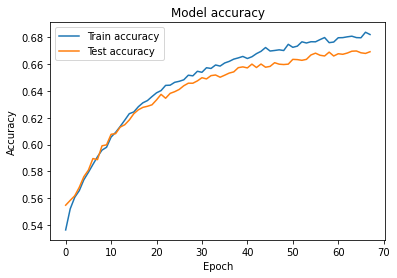

In [12]:
# plot train and test accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

#plt.savefig('Q1(b)accuracy.png')

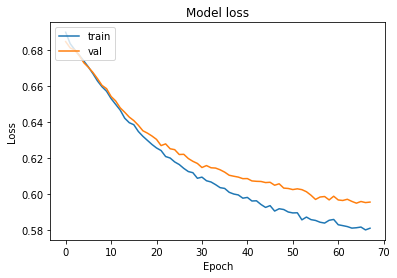

In [13]:
# plot train and test losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

#plt.savefig('Q1(b)loss.png')

In [14]:
# comment on line plots

# explain use of early stopping 


## Question 2

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection.

You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

### Part a

Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. This might take a while to run.

In [15]:
batch_size = [128, 256, 512, 1024]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
no_epochs = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
no_folds = 5

In [16]:
from tensorflow.keras.callbacks import Callback

class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
timing_callback = TimingCallback()

In [17]:
# 5-fold cross-validation on training partition
kfold = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [18]:
batch_acc ={}
batch_time ={}

# Experiment on batch sizes
# Iterating through all batch sizes
for batch_no in batch_size:
    fold_acc = []
    fold_time = []
    fold_no = 1

    print("\n------- Batch Size: " + str(batch_no) + " -------")

    # Iterating through each split of training data
    for train, test in kfold.split(X_train_scaled, y_train):
        print("\nTraining for Fold " + str(fold_no) + " ...")
        # define the model
        model = Sequential([
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid'),
        ])

        # compile the model
        model.compile(optimizer= opt,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        # fit the model
        history = model.fit(X_train_scaled[train], y_train[train], 
                            epochs=no_epochs, 
                            batch_size=batch_no, 
                            verbose = 2, 
                            use_multiprocessing=True,
                            callbacks=[early_stop, timing_callback],
                            validation_data=(X_test_scaled, y_test))

        
        
        # Storing history of every k-fold
        time_ = timing_callback.times
        acc_ = model.evaluate(X_train_scaled[test], y_train[test], verbose=0)
        #print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {acc_[0]}; {model.metrics_names[1]} of {acc_[1]}%')
        fold_acc.append(acc_[1])
        fold_time.append(time_)
        
        # increase fold number
        fold_no += 1

    # Storing history for every batch size
    batch_acc[batch_no] = {"Accuracy":fold_acc}
    batch_time[batch_no] = {"Time":fold_time}                 


------- Batch Size: 128 -------

Training for Fold 1 ...
Epoch 1/100
798/798 - 2s - loss: 0.6904 - accuracy: 0.5363 - val_loss: 0.6845 - val_accuracy: 0.5509 - 2s/epoch - 3ms/step
Epoch 2/100
798/798 - 2s - loss: 0.6837 - accuracy: 0.5504 - val_loss: 0.6832 - val_accuracy: 0.5534 - 2s/epoch - 2ms/step
Epoch 3/100
798/798 - 2s - loss: 0.6811 - accuracy: 0.5585 - val_loss: 0.6806 - val_accuracy: 0.5611 - 2s/epoch - 2ms/step
Epoch 4/100
798/798 - 2s - loss: 0.6780 - accuracy: 0.5648 - val_loss: 0.6776 - val_accuracy: 0.5653 - 2s/epoch - 2ms/step
Epoch 5/100
798/798 - 2s - loss: 0.6747 - accuracy: 0.5697 - val_loss: 0.6773 - val_accuracy: 0.5648 - 2s/epoch - 2ms/step
Epoch 6/100
798/798 - 2s - loss: 0.6722 - accuracy: 0.5744 - val_loss: 0.6726 - val_accuracy: 0.5714 - 2s/epoch - 2ms/step
Epoch 7/100
798/798 - 2s - loss: 0.6683 - accuracy: 0.5802 - val_loss: 0.6717 - val_accuracy: 0.5755 - 2s/epoch - 2ms/step
Epoch 8/100
798/798 - 2s - loss: 0.6641 - accuracy: 0.5861 - val_loss: 0.6670 - v

In [19]:
batch_size_plot = []
mean_accuracy_plot =[]

for batch_size, acc in batch_acc.items():
  batch_size_acc = acc["Accuracy"]
  mean_fold_acc = sum(batch_size_acc)/len(batch_size_acc)

  batch_size_plot.append(batch_size)
  mean_accuracy_plot.append(mean_fold_acc)

Text(0.5, 0, 'Batch size')

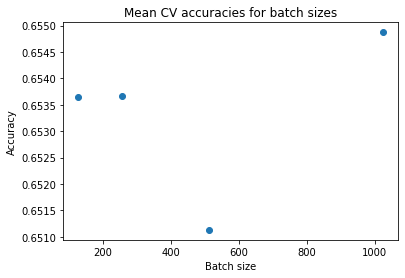

In [20]:
plt.scatter(batch_size_plot,mean_accuracy_plot)
plt.title('Mean CV accuracies for batch sizes')
plt.ylabel('Accuracy')
plt.xlabel('Batch size')

#plt.savefig('Q2(a)mean cross-validation accuracies.png')

### Part b

Create a table of time taken to train the network on the last epoch against different batch sizes. (Hint: Introduce a callback)

In [21]:
time_taken_fold = []

for batch_sizes, data in batch_time.items():
  time_taken_per_batch = data["Time"]
  i = 1
  for time_taken in time_taken_per_batch:
    time_taken_fold.append(time_taken[-1])
    i+=1

#print(time_taken_fold) 
#print(len(time_taken_fold))

In [22]:
all_time = []

time_128 = sum(time_taken_fold[0:5])
all_time.append(time_128)

time_256 = sum(time_taken_fold[5:10])
all_time.append(time_256)

time_512 = sum(time_taken_fold[10:15])
all_time.append(time_512)

time_1024 = sum(time_taken_fold[15:20])
all_time.append(time_1024)

#print(all_time)

In [23]:
data = {'batch_size':batch_size , 'time_taken': all_time}

df = pd.DataFrame(data=data)

df.head()

,batch_size,time_taken
0,1024,8.550996
1,1024,6.418202
2,1024,5.997085
3,1024,3.425350


### Part c

Select the optimal batch size and state a reason for your selection.

In [24]:
# select optimal batch size

# state reason


### Part d

What happens when batch size increases, and why does it happen?

In [25]:
# what happens when batch size increase

# why happen


### Part e

Plot the train and test accuracies against epochs for the optimal batch size in a line plot.

Note: use this optimal batch size for the rest of the experiments.

In [26]:
# optimal batch size
batch_size = 128

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
no_epochs = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [27]:
#define the model
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

# compile the model
model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit the model
history = model.fit(X_train_scaled, y_train,
          epochs=no_epochs, 
          batch_size=batch_size, 
          verbose = 2, 
          use_multiprocessing=True,
          callbacks=[early_stop],
          validation_data=(X_test_scaled, y_test)) 

Epoch 1/100
997/997 - 3s - loss: 0.6889 - accuracy: 0.5369 - val_loss: 0.6841 - val_accuracy: 0.5513 - 3s/epoch - 3ms/step
Epoch 2/100
997/997 - 2s - loss: 0.6826 - accuracy: 0.5547 - val_loss: 0.6815 - val_accuracy: 0.5561 - 2s/epoch - 2ms/step
Epoch 3/100
997/997 - 3s - loss: 0.6793 - accuracy: 0.5589 - val_loss: 0.6797 - val_accuracy: 0.5614 - 3s/epoch - 3ms/step
Epoch 4/100
997/997 - 3s - loss: 0.6772 - accuracy: 0.5645 - val_loss: 0.6756 - val_accuracy: 0.5669 - 3s/epoch - 3ms/step
Epoch 5/100
997/997 - 4s - loss: 0.6734 - accuracy: 0.5709 - val_loss: 0.6730 - val_accuracy: 0.5763 - 4s/epoch - 4ms/step
Epoch 6/100
997/997 - 4s - loss: 0.6687 - accuracy: 0.5823 - val_loss: 0.6702 - val_accuracy: 0.5794 - 4s/epoch - 4ms/step
Epoch 7/100
997/997 - 3s - loss: 0.6657 - accuracy: 0.5860 - val_loss: 0.6663 - val_accuracy: 0.5880 - 3s/epoch - 3ms/step
Epoch 8/100
997/997 - 4s - loss: 0.6608 - accuracy: 0.5942 - val_loss: 0.6641 - val_accuracy: 0.5885 - 4s/epoch - 4ms/step
Epoch 9/100
997/

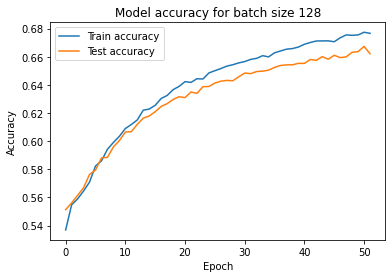

In [28]:
# plot train and test accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy for batch size 128')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

#plt.savefig('Q1(e)accuracy.png')

## Question 3

Find the optimal number of hidden neurons for first hidden layer of the 5-layer network (input layer, 3 hidden layers, output layer) designed in Question 1 and 2.

### Part a

Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

Continue using 5-fold cross validation on training dataset.

In [29]:
hidden_neurons = [64, 128, 256]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
no_epochs = 100
batch_size = 128
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
no_folds = 5

In [30]:
# 5-fold cross-validation on training partition
kfold = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [31]:
batch_acc ={}

# Experiment on batch sizes
# Iterating through all batch sizes
for neuron_no in hidden_neurons:
    fold_acc = []
    fold_no = 1

    print("\n------- Batch Size: " + str(batch_no) + " -------")

    # Iterating through each split of training data
    for train, test in kfold.split(X_train_scaled, y_train):
        print("\nTraining for Fold " + str(fold_no) + " ...")
        # define the model
        model = Sequential([
            Dense(neuron_no, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid'),
        ])

        # compile the model
        model.compile(optimizer= opt,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        # fit the model
        history = model.fit(X_train_scaled[train], y_train[train], 
                            epochs=no_epochs, 
                            batch_size=batch_size, 
                            verbose = 2, 
                            use_multiprocessing=True,
                            callbacks=[early_stop],
                            validation_data=(X_test_scaled, y_test))

        
        
        # Storing history of every k-fold
        acc_ = model.evaluate(X_train_scaled[test], y_train[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {acc_[0]}; {model.metrics_names[1]} of {acc_[1]}%')
        fold_acc.append(acc_[1])
        
        # increase fold number
        fold_no += 1

    # Storing history for every batch size
    batch_acc[neuron_no] = {"Accuracy":fold_acc}               


------- Batch Size: 1024 -------

Training for Fold 1 ...
Epoch 1/100
798/798 - 4s - loss: 0.6909 - accuracy: 0.5346 - val_loss: 0.6858 - val_accuracy: 0.5441 - 4s/epoch - 6ms/step
Epoch 2/100
798/798 - 3s - loss: 0.6850 - accuracy: 0.5486 - val_loss: 0.6842 - val_accuracy: 0.5500 - 3s/epoch - 3ms/step
Epoch 3/100
798/798 - 3s - loss: 0.6826 - accuracy: 0.5519 - val_loss: 0.6826 - val_accuracy: 0.5550 - 3s/epoch - 4ms/step
Epoch 4/100
798/798 - 3s - loss: 0.6803 - accuracy: 0.5594 - val_loss: 0.6800 - val_accuracy: 0.5582 - 3s/epoch - 4ms/step
Epoch 5/100
798/798 - 3s - loss: 0.6786 - accuracy: 0.5623 - val_loss: 0.6794 - val_accuracy: 0.5600 - 3s/epoch - 4ms/step
Epoch 6/100
798/798 - 3s - loss: 0.6764 - accuracy: 0.5683 - val_loss: 0.6767 - val_accuracy: 0.5713 - 3s/epoch - 4ms/step
Epoch 7/100
798/798 - 3s - loss: 0.6745 - accuracy: 0.5709 - val_loss: 0.6753 - val_accuracy: 0.5695 - 3s/epoch - 4ms/step
Epoch 8/100
798/798 - 3s - loss: 0.6722 - accuracy: 0.5748 - val_loss: 0.6733 - 

In [32]:
hidden_neurons_plot = []
mean_accuracy_plot =[]

for hidden_neurons, acc in batch_acc.items():
  hidden_neurons_acc = acc["Accuracy"]
  mean_fold_acc = sum(hidden_neurons_acc)/len(hidden_neurons_acc)

  hidden_neurons_plot.append(hidden_neurons)
  mean_accuracy_plot.append(mean_fold_acc)

Text(0.5, 0, 'Number of hidden-layer neurons')

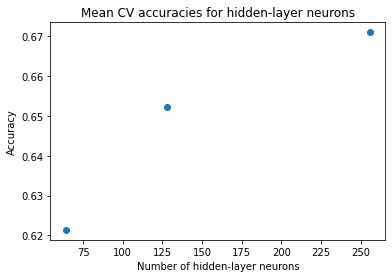

In [33]:
plt.scatter(hidden_neurons_plot,mean_accuracy_plot)
plt.title('Mean CV accuracies for hidden-layer neurons')
plt.ylabel('Accuracy')
plt.xlabel('Number of hidden-layer neurons')

#plt.savefig('Q2(a)mean cross-validation accuracies.png')

### Part b

Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [34]:
# select optimal number of neurons for hidden layer

# state rationale


### Part c

Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [35]:
# optimal number of neurons
hidden_units = 64 # to be updated

batch_size = 128
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
no_epochs = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [36]:
#define the model
model = Sequential([
    Dense(hidden_units, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

# compile the model
model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit the model
history = model.fit(X_train_scaled, y_train,
          epochs=no_epochs, 
          batch_size=batch_size, 
          verbose = 2, 
          use_multiprocessing=True,
          callbacks=[early_stop],
          validation_data=(X_test_scaled, y_test)) 

Epoch 1/100
997/997 - 2s - loss: 0.6893 - accuracy: 0.5358 - val_loss: 0.6850 - val_accuracy: 0.5502 - 2s/epoch - 2ms/step
Epoch 2/100
997/997 - 2s - loss: 0.6840 - accuracy: 0.5499 - val_loss: 0.6827 - val_accuracy: 0.5558 - 2s/epoch - 2ms/step
Epoch 3/100
997/997 - 2s - loss: 0.6817 - accuracy: 0.5558 - val_loss: 0.6819 - val_accuracy: 0.5565 - 2s/epoch - 2ms/step
Epoch 4/100
997/997 - 2s - loss: 0.6793 - accuracy: 0.5608 - val_loss: 0.6791 - val_accuracy: 0.5634 - 2s/epoch - 2ms/step
Epoch 5/100
997/997 - 2s - loss: 0.6768 - accuracy: 0.5675 - val_loss: 0.6777 - val_accuracy: 0.5649 - 2s/epoch - 2ms/step
Epoch 6/100
997/997 - 2s - loss: 0.6742 - accuracy: 0.5727 - val_loss: 0.6751 - val_accuracy: 0.5719 - 2s/epoch - 2ms/step
Epoch 7/100
997/997 - 2s - loss: 0.6721 - accuracy: 0.5751 - val_loss: 0.6729 - val_accuracy: 0.5761 - 2s/epoch - 2ms/step
Epoch 8/100
997/997 - 2s - loss: 0.6700 - accuracy: 0.5790 - val_loss: 0.6703 - val_accuracy: 0.5780 - 2s/epoch - 2ms/step
Epoch 9/100
997/

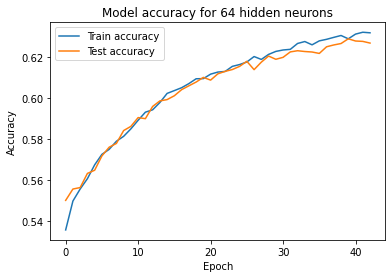

In [37]:
# plot train and test accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy for 64 hidden neurons') # to be updated
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

#plt.savefig('Q1(e)accuracy.png')

### Part d

How does dropouts work, and what is the purpose of dropouts?

In [38]:
# how dropouts work

# purpose of dropouts


### Part e

Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach.

Note: use this optimal number of neurons for the rest of the experiments.

## Question 4

In this section, we will understand the utility of such a neural network in real world scenarios.

### Part a

Record yourself with a wav file using (https://voice-recorder-online.com/) for 5 seconds, either in a positive or a negative manner. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.

### Part b

Do a model prediction on your sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.

### Part c

Find the most important features on the model prediction for your test sample using SHAP. Plot the local feature importance with a force plot and explain your
observations. (Refer to the documentation and these three useful references: https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16, https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)

## Conclusion

Possible discussion pointers for conclusion:

Besides summarising the key findings from each question, take a step back to analyse the entire modelling pipeline and think about ways to improve it. Here are some aspects of the pipeline that you can consider:

*   We now have a classifier that predicts the speech polarity. What are some limitations of the current approach (using FFNs to model such engineered features)?
*   Out of the parameters that were tuned, which was most impactful in terms of improving the model performance and what could be some reasons for that?
*   Considering that audio tracks are originally waveforms, what are some alternative approaches to achieve the goal of genre classification? What kind of neural network architectures will be used instead?
*   What other datasets and tasks can this approach of modelling waveform data be used for? What changes to the pipeline, if any, will you have to make when approaching these problems?
*   You are encouraged to include your own pointers!